<a href="https://colab.research.google.com/github/aeneaswiener/intrinsic-value-model/blob/master/intrinsic_value_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup


In [1]:
%matplotlib inline
from copy import copy
from google.colab import widgets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from toolz.dicttoolz import valmap

# Simulation setup

In [2]:
PS_RATIO = 'ps_ratio'
PS_RATIO_ACTUAL ='ps_ratio_actual'
PE_RATIO = 'pe_ratio'
PE_RATIO_ACTUAL = 'pe_ratio_actual'
MARKET_CAP_ACTUAL = 'market_cap_actual'
PROFIT_MARGIN = 'profit_margin'
PROFIT_MARGIN_ACTUAL = 'profit_margin_actual'
EARNINGS = 'earnings'
EARNINGS_ACTUAL = 'earnings_actual'
EARNINGS_INSPECT_YEAR_NPV = 'earnings_inspec_year_npv' # The dicounted value of future ernings at the time of inspect_year
EARNINGS_FPV = 'discounted_future_earnings' # sum of all future (after time t) ernings discounted to time t, for all t
EARNINGS_FPV_INSPECT_YEAR = "discounted_future_earnings_inspect_year"
EARNINGS_FPV_PCT_CHANGE = 'discounted_future_earnings_pct_change'
EARNINGS_FPV_PCT_CHANGE_INSPECT_YEAR = 'discounted_future_earnings_pct_change_inspect_year'
SALES = 'sales'
SALES_ACTUAL = 'sales_actual'
SALES_GROWTH_RATE = 'sales_growth_rate'
YEAR = 'year'
ACTUAL = 'actual'
INTEREST_RATE = 'interest_rate'
TOTAL_EARNINGS_T0_PV = 'total_earnings_t0_pv'
TOTAL_EARNINGS_TO_BREAKEVEN = 'total_earnings_to_breakeven'
UPPER = 'upper'
MID = 'mid'
LOWER = 'lower'

In [ ]:
def derivd_company_actuals(company_actuals):
  company_actuals[PROFIT_MARGIN_ACTUAL] = company_actuals[EARNINGS_ACTUAL]/company_actuals[SALES_ACTUAL]
  company_actuals[PS_RATIO_ACTUAL] = company_actuals[MARKET_CAP_ACTUAL]/company_actuals[SALES_ACTUAL]
  company_actuals[PE_RATIO_ACTUAL] = company_actuals[MARKET_CAP_ACTUAL]/company_actuals[EARNINGS_ACTUAL]

  return company_actuals

In [4]:
def get_sim_results(sim_config):
  years_total = 500 

  inspect_year=sim_config['inspect_year'] - sim_config['company_founded_year']
  interest_rate=sim_config['interest_rate']
  sales_growth_years=sim_config['sales_growth_years']
  profit_margin_start_value=sim_config['profit_margin_start_value']
  profit_margin_terminal_value=sim_config['profit_margin_terminal_value']
  sales_start_value=sim_config['sales_start_value']
  sales_terminal_value=sim_config['sales_terminal_value']
  company_ticker=sim_config['company_ticker']

  profit_margin = pd.Series([np.nan]*years_total, name=PROFIT_MARGIN)
  profit_margin.index.name = YEAR
  profit_margin[0] = profit_margin_start_value
  profit_margin[sales_growth_years] = profit_margin_terminal_value
  profit_margin[years_total-1] = profit_margin[sales_growth_years]
  profit_margin = profit_margin.interpolate(method='linear')

  def get_sales(sales_start_value=sales_start_value,
                sales_terminal_value=sales_terminal_value,
                sales_growth_years=sales_growth_years,
                years_total=years_total,
                inspect_year=inspect_year):

    def y(growth_rate, t):
      return sales_start_value*np.power(growth_rate, t)
    growth_rate = np.power(sales_terminal_value/sales_start_value, 1/sales_growth_years)

    sales = pd.Series([np.nan]*years_total, name=SALES)
    sales.index.name = YEAR
    sales[0:sales_growth_years] = list(map(lambda t: y(growth_rate, t), sales[0:sales_growth_years].index.to_list()))
    sales[0] = sales_start_value
    sales[sales_growth_years] = sales_terminal_value
    sales[years_total-1] = sales_terminal_value
    sales = sales.interpolate(method='linear')

    return growth_rate, sales

  growth_rate, sales = get_sales(
    sales_start_value=sales_start_value,
    sales_growth_years=sales_growth_years,
    sales_terminal_value=sales_terminal_value,
    years_total=years_total
  )
  earnings = sales*profit_margin
  earnings.name = EARNINGS

  earnings_inspect_year = earnings[earnings.index >= inspect_year]
  earnings_inspect_year_npv = earnings_inspect_year*np.power((1+interest_rate), -earnings_inspect_year.reset_index().index)
  earnings_inspect_year_npv.name = EARNINGS_INSPECT_YEAR_NPV

  earnings_fpv = earnings.iloc[::-1].expanding().apply(lambda x: np.sum(x*np.power((1+interest_rate), -x.reset_index().iloc[::-1].index))).iloc[::-1]
  earnings_fpv.name = EARNINGS_FPV

  sim = pd.concat((profit_margin, earnings, earnings_inspect_year_npv, earnings_fpv, sales), axis=1)
  sim.index += sim_config['company_founded_year']

  sim[PS_RATIO] = sim[EARNINGS_FPV]/sim[SALES]
  sim[PE_RATIO] = sim[EARNINGS_FPV]/sim[EARNINGS]

  sim[EARNINGS_FPV_PCT_CHANGE] = sim[EARNINGS_FPV].pct_change()

  sim_results_metadata = {
      SALES_GROWTH_RATE: growth_rate,
      EARNINGS_FPV_INSPECT_YEAR: sim.loc[inspect_year + company_founded_year][EARNINGS_FPV],
      EARNINGS_FPV_PCT_CHANGE_INSPECT_YEAR: sim.loc[inspect_year + company_founded_year][EARNINGS_FPV_PCT_CHANGE],
      TOTAL_EARNINGS_TO_BREAKEVEN: np.sum(earnings[earnings < 0])
  }
  return sim, sim_results_metadata

In [5]:
def plot_sim(sim=None, sim_lower=None, sim_upper=None, company_actuals=None, sim_config=None, sim_results_metadata=None):
  # plt.rc('font', size=9)

  plot_years = 100

  sim = sim.join(company_actuals, how='left')

  sim_range = (
    pd.concat(
      [sim_lower, 
      sim_upper],
      axis=1, 
      keys=['lower', 'upper'])
    .swaplevel(0, 1, axis=1)
    .sort_index(axis=1, ascending=[True, False])
  )
  print('Inputs')
  grid0 = widgets.Grid(1, 1)
  with grid0.output_to(0, 0):
    df = pd.DataFrame.from_dict({
      "Value": list(sim_config.values()), 
      "-margin": list(sim_config_lower.values()), 
      "+margin": list(sim_config_upper.values())
    })
    df.index = sim_config.keys()
    print(df)

  print('Results')
  grid = widgets.Grid(2, 4, style="vertical-align: top;")
  inspect_year=sim_config['inspect_year']
  company_ticker=sim_config['company_ticker']
  growth_rate = sim_results_metadata[SALES_GROWTH_RATE]

  with grid.output_to(0, 0):
    ax = sim[[SALES, SALES_ACTUAL]][:plot_years].plot(style=['.-', '.'], color=['orange', 'red'], figsize=(4,4))
    ax.fill_between(sim.index, sim_range[SALES][LOWER], sim_range[SALES][UPPER], facecolor='grey', alpha=0.3, label=None)
    ax.axvline(inspect_year, color="grey", linestyle="--")
    ax.set_title("%s sales" % company_ticker)
    ax.set_ylabel("billion (USD)")
    ax.set_xlim(sim_config['company_founded_year'], sim_config['company_founded_year'] + plot_years)
    plt.legend(bbox_to_anchor=(1.02, -0.15), loc='upper right',
               labels=["sales {:.2%} growth/yr)".format(growth_rate-1), SALES_ACTUAL])
  with grid.output_to(0, 1):
    ax = sim[[PROFIT_MARGIN, PROFIT_MARGIN_ACTUAL]][:plot_years].plot(style=['.-', '.'], color=['orange', 'red'], figsize=(4,4))
    ax.fill_between(sim.index, sim_range[PROFIT_MARGIN][LOWER], sim_range[PROFIT_MARGIN][UPPER], facecolor='grey', alpha=0.3, label=None)
    ax.set_title("%s profit margin" % company_ticker)
    ax.axvline(inspect_year, color="grey", linestyle="--")
    ax.set_xlim(sim_config['company_founded_year'], sim_config['company_founded_year'] + plot_years)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=2))
    plt.legend(bbox_to_anchor=(1.02, -0.15), loc='upper right')
  with grid.output_to(0, 2):
    ax = sim[[EARNINGS, EARNINGS_INSPECT_YEAR_NPV, EARNINGS_ACTUAL]][:plot_years].plot(style=['.-', '.-', '.'], color=['black', 'grey', 'red'], figsize=(4,4))
    ax.fill_between(sim.index, sim_range[EARNINGS][LOWER], sim_range[EARNINGS][UPPER], facecolor='grey', alpha=0.3, label=None)
    ax.fill_between(sim.index, sim_range[EARNINGS_INSPECT_YEAR_NPV][LOWER], sim_range[EARNINGS_INSPECT_YEAR_NPV][UPPER], where=sim.index > inspect_year, facecolor='grey', alpha=0.3, label=None)
    # ax.fill_between(sim.index, [0]*len(sim.index), sim[EARNINGS], where=sim.index < inspect_year, facecolor='grey', alpha=0.3, label="past earnings")
    # ax.fill_between(sim.index, [0]*len(sim.index), sim[EARNINGS_INSPECT_YEAR_NPV], where=sim.index > inspect_year, facecolor='blue', alpha=0.3, label="future earnings (discounted)")
    ax.set_xlim(sim_config['company_founded_year'], sim_config['company_founded_year'] + plot_years)
    ax.set_title("%s earnings" % company_ticker)
    ax.set_ylabel("billion (USD)")
    ax.axvline(inspect_year, color="grey", linestyle="--")
    plt.legend(bbox_to_anchor=(1.02, -0.15), loc='upper right')
  with grid.output_to(0, 3):
    ax = sim[[EARNINGS_FPV, MARKET_CAP_ACTUAL]][:plot_years].plot(style=['.-', '.'], color=['black', 'red'], figsize=(4,4))
    ax.fill_between(sim.index, sim_range[EARNINGS_FPV][LOWER], sim_range[EARNINGS_FPV][UPPER], facecolor='grey', alpha=0.3, label=None)
    ax.set_title("%s valuation" % company_ticker)
    ax.set_ylabel("billion (USD)")
    ax.axvline(inspect_year, color="grey", linestyle="--")
    x = sim.index
    y_sim = sim[EARNINGS_FPV]
    y_act = sim[MARKET_CAP_ACTUAL]
    ax.fill_between(x, y_sim, y_act, where=y_sim > y_act, facecolor='green', alpha=0.3, label="undervalued")
    ax.fill_between(x, y_sim, y_act, where=y_sim <= y_act, facecolor='red', alpha=0.3, label="overvalued")
    ax.set_xlim(sim_config['company_founded_year'], sim_config['company_founded_year'] + plot_years)
    plt.legend()
    plt.legend(bbox_to_anchor=(1.02, -0.15), loc='upper right')
    plt.show()
  with grid.output_to(1, 0):
    ax = sim[[PS_RATIO, PS_RATIO_ACTUAL]][:plot_years].plot(style=['.-', '.'], color=['black', 'red'], figsize=(4,4))
    ax.fill_between(sim.index, sim_range[PS_RATIO][LOWER], sim_range[PS_RATIO][UPPER], facecolor='grey', alpha=0.3, label=None)
    ax.set_title("Price/Sales ratio")
    ax.set_ylabel("P/S")
    ax.axvline(inspect_year, color="grey", linestyle="--")
    ax.set_xlim(sim_config['company_founded_year'], sim_config['company_founded_year'] + plot_years)
    plt.legend(bbox_to_anchor=(1.02, -0.15), loc='upper right')
  with grid.output_to(1, 2):
    ax = sim[[PE_RATIO, PE_RATIO_ACTUAL]][:plot_years].plot(style=['.-', '.'], color=['black', 'red'], figsize=(4,4))
    ax.fill_between(sim.index, sim_range[PE_RATIO][LOWER], sim_range[PE_RATIO][UPPER], facecolor='grey', alpha=0.3, label=None)
    ax.set_title("Price/Earnings ratio")
    ax.set_ylabel("P/E")
    ax.axvline(inspect_year, color="grey", linestyle="--")
    ax.set_xlim(sim_config['company_founded_year'], sim_config['company_founded_year'] + plot_years)
    plt.legend(bbox_to_anchor=(1.02, -0.15), loc='upper right')

  print('Results metadata')
  grid2 = widgets.Grid(1, 1)
  with grid2.output_to(0, 0):
    df = pd.DataFrame.from_dict(valmap(lambda x: [x], sim_results_meta), orient='index',
                        columns=['Value']).rename_axis('result')
    print(df)

Inputs


""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

                               Value -margin +margin
company_founded_year            1975    1975    1975
inspect_year                    2020    2020    2020
interest_rate                   0.05   0.025   0.075
sales_growth_years                70      70      70
profit_margin_start_value       0.15    0.15    0.15
profit_margin_terminal_value     0.3     0.3     0.3
sales_start_value                 10      10      10
sales_terminal_value             500     500     500
company_ticker                  MSFT    MSFT    MSFT
input_data                    simfin  simfin  simfin


<IPython.core.display.Javascript object>

Results


,,,
,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

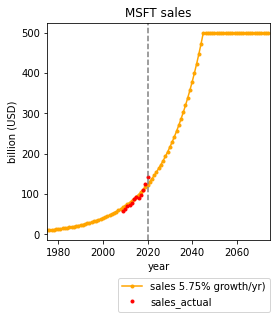

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

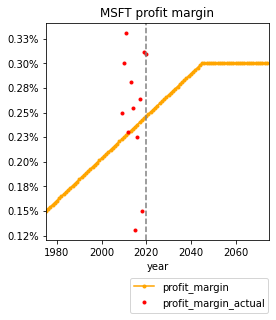

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

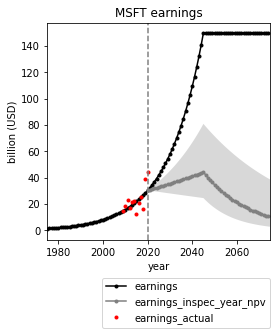

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

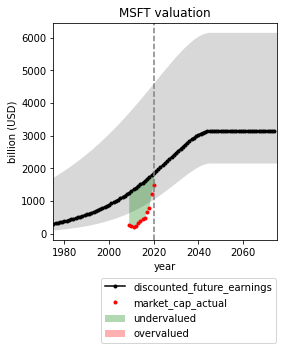

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

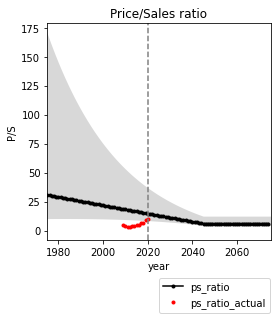

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

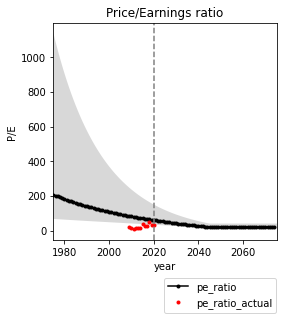

<IPython.core.display.Javascript object>

Results metadata


""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

                                                          Value
result                                                         
sales_growth_rate                                      1.057477
discounted_future_earnings_inspect_year             1850.102578
discounted_future_earnings_pct_change_inspect_year     0.033250
total_earnings_to_breakeven                            0.000000


<IPython.core.display.Javascript object>

In [8]:
#@title Simulation

interest_rate = 0.05 #@param {type:"number"}

profit_margin_start_value = 0.15 #@param {type:"number"}
profit_margin_terminal_value = 0.3 #@param {type:"number"}

sales_start_value =  10#@param {type:"number"}
sales_terminal_value =  500#@param {type:"number"}
sales_growth_years = 70 #@param {type:"number"}

company_founded_year = 1975 #@param {type:"number"}
inspect_year=2020 #-company_founded_year
company_ticker = 'MSFT' #@param {type:"string"}

company_actuals_raw = pd.DataFrame.from_dict({
  'sales_actual': {
    2009: 58.43,
    2010: 62.48,
    2011: 69.94,
    2012: 73.72,
    2013: 77.84,
    2014: 86.83,
    2015: 93.58,
    2016: 91.15,
    2017: 96.57,
    2018: 110.36,
    2019: 125.84,
    2020: 143.01
  },
  'earnings_actual': {
    2009: 14.56,
    2010: 18.76,
    2011: 23.15,
    2012: 16.97,
    2013: 21.86,
    2014: 22.07,
    2015: 12.19,
    2016: 20.53,
    2017: 25.48,
    2018: 16.57,
    2019: 39.24,
    2020: 44.28
  },
 'market_cap_actual': {
    2009: 272.95,
    2010: 244.48,
    2011: 221.74,
    2012: 227.08,
    2013: 315.84,
    2014: 388.03,
    2015: 450.81,
    2016: 494.69,
    2017: 668.30,
    2018: 792.27,
    2019: 1217.40,
    2020: 1500.00
  }
})
company_actuals_raw.index.name = YEAR
company_actuals = derivd_company_actuals(company_actuals_raw)

sim_config = dict(
    company_founded_year=company_founded_year,
    inspect_year=inspect_year,
    interest_rate=interest_rate,
    sales_growth_years=sales_growth_years,
    profit_margin_start_value=profit_margin_start_value,
    profit_margin_terminal_value=profit_margin_terminal_value,
    sales_start_value=sales_start_value,
    sales_terminal_value=sales_terminal_value,
    company_ticker=company_ticker,
    input_data='simfin'
)

sim_results, sim_results_meta = get_sim_results(sim_config)

sim_config_upper = copy(sim_config)
sim_config_lower = copy(sim_config)
sim_config_upper['interest_rate'] *= 1.5
sim_config_lower['interest_rate'] *= 0.5
sim_results_upper, sim_results_upper_meta = get_sim_results(sim_config_upper)
sim_results_lower, sim_results_lower_meta = get_sim_results(sim_config_lower)

plot_sim(
    sim=sim_results, 
    sim_lower=sim_results_lower,
    sim_upper=sim_results_upper,
    company_actuals=company_actuals,
    sim_config=sim_config,
    sim_results_metadata=sim_results_meta
)